In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from jupyter_utils import AllDataset

# import tensorflow as tf
# tf.compat.v1.disable_v2_behavior()
# tf.random.set_seed(1)
# from cxplain import CXPlain


data_dir = '../drp-data/'
GDSC_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/gdsc_rma_gene_expr.csv'
TCGA_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/tcga_log2_gene_expr.csv'

TCGA_TISSUE = 'preprocessed/tissue_type/TCGA_tissue_one_hot.csv'
GDSC_TISSUE = 'preprocessed/tissue_type/GDSC_tissue_one_hot.csv'

GDSC_lnIC50 = 'preprocessed/drug_response/gdsc_lnic50.csv'
TCGA_DR = 'preprocessed/drug_response/tcga_drug_response.csv'

dataset = AllDataset(data_dir, GDSC_GENE_EXPRESSION, TCGA_GENE_EXPRESSION, 
                     GDSC_lnIC50, TCGA_DR, TCGA_TISSUE)


In [18]:
import torch

In [11]:
def get_tcga_dr_bin(drug):
    x = dataset.tcga_dr[drug].dropna()
    y1 = x.isin(['Clinical Progressive Disease', 'Stable Disease'])
    return y1.values*1

In [12]:
dataset.tcga_dr['tamoxifen'].dropna()

7f2c3de9-a1b9-413a-821c-02dbcad4ea0b.FPKM.txt.gz               Complete Response
0e397288-82e4-48c7-9332-2ce733befdae.FPKM.txt.gz    Clinical Progressive Disease
f5e4c398-d9db-4cd0-bd12-3751a624d377.FPKM.txt.gz                  Stable Disease
4ce3e99a-a195-414c-a967-7d3795d48934.FPKM.txt.gz               Complete Response
1953cac0-8088-44ea-b371-e8b98097d871.FPKM.txt.gz               Complete Response
be6d9906-45f4-4e32-83d0-327fa8c21666.FPKM.txt.gz                  Stable Disease
33fa1673-1d0d-4838-a313-1929c5af60d1.FPKM.txt.gz               Complete Response
1f81c6d5-6a0b-43d8-b4e9-64ccd4d76291.FPKM.txt.gz               Complete Response
eff0bfff-4b66-4fd1-9f5b-ceb3cf6c7c81.FPKM.txt.gz    Clinical Progressive Disease
899a4fae-569f-463c-8cb1-049b9d50b9f4.FPKM.txt.gz               Complete Response
9ed9fdc8-a437-4f4b-8ef8-e3f0c219baca.FPKM.txt.gz               Complete Response
a142c4c1-3c63-4338-968a-7c1b494b5d76.FPKM.txt.gz    Clinical Progressive Disease
943f8d82-d39d-4621-a357-6ff6

In [34]:
y_true = get_tcga_dr_bin('tamoxifen')

In [3]:
from gene_finding.models import load_model, EnsModel
drug = 'tamoxifen'
gdsc_expr, gdsc_dr, _, test_tcga_expr = dataset.filter_and_normalize_data(drug, load_normalizer=True)
    
models = []

for i in range(1, 11):
    mod = load_model(seed=i,drug=drug,n_genes=len(dataset.genes))
    mod.eval()
    models.append(mod)
ens = EnsModel(models)

In [14]:
test_tcga_expr.shape

(20, 15650)

In [16]:
def get_masked_data_for_CXPlain(model, expr):
    x_train = torch.FloatTensor(expr.values)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)

    if type(model) == EnsModel:
        for m in model.model_list:
            m.to(device)

    model.to(device)
    model.eval()

    y_pred = model(x_train.to(device)).cpu().detach().numpy()
    n_genes = x_train.shape[1]

    mask = torch.ones((n_genes, n_genes)) - torch.eye(n_genes)

    list_of_masked_outs = []
    for i, sample in enumerate(x_train):
        if (i+1) % 100 == 0: print(i)
        masked_sample = sample*mask
        data = torch.utils.data.TensorDataset(masked_sample)
        data = torch.utils.data.DataLoader(data, batch_size=512, shuffle=False)
        
        ret_val = []
        for [x] in data:
            x = x.to(device)
            ret_val.append(model(x))

        ret_val = torch.cat(ret_val, axis=0).unsqueeze(0).cpu().detach().numpy()
        list_of_masked_outs.append(ret_val)

    masked_outs = np.concatenate(list_of_masked_outs)
    return (y_pred, masked_outs)

In [31]:
y_pred, masked_data = get_masked_data_for_CXPlain(ens, test_tcga_expr)

cuda


In [35]:
outs = pd.DataFrame(index=range(len(y_pred)), columns=['y', 'y_hat'])
outs['y']=y_true
outs['y_hat']=y_pred[:,0]
outs

,y,y_hat
0,0,0.120357
1,1,0.172462
2,1,0.500911
3,0,0.093035
4,0,0.062783
5,1,0.198576
6,0,-0.060881
7,0,-0.192934
8,1,0.188903
9,0,0.123186


In [21]:
masked_data.shape

(20, 15650, 1)

In [44]:
y_pred = torch.Tensor(y_pred)
masked_data = torch.Tensor(masked_data)
y_true = torch.Tensor(y_true).view(-1,1)

In [50]:
yp2 = (y_pred - y_pred.min())/(y_pred - y_pred.min()+1e-7).max()
yp2

tensor([[0.5346],
        [0.5983],
        [1.0000],
        [0.5012],
        [0.4642],
        [0.6302],
        [0.3129],
        [0.1514],
        [0.6184],
        [0.5380],
        [0.0000],
        [0.8689],
        [0.2019],
        [0.3510],
        [0.2552],
        [0.3133],
        [0.4440],
        [0.0789],
        [0.3443],
        [0.4404]])

In [52]:
loss_all = torch.nn.functional.binary_cross_entropy(yp2, y_true, reduction='none')

In [56]:
m2 = torch.relu((masked_data - y_pred.min())/(masked_data - y_pred.min() + 1e-7).max())

In [58]:
m2.shape

torch.Size([20, 15650, 1])

In [64]:
yt2 = y_true.repeat((1, 15650)).view(-1, 15650, 1)

In [67]:
error_without_one_feature = torch.nn.functional.binary_cross_entropy(m2, yt2, reduction='none')

In [68]:
error_without_one_feature.shape

torch.Size([20, 15650, 1])

In [69]:
loss_all.shape

torch.Size([20, 1])

In [72]:
delta_errors = torch.max(error_without_one_feature.view(-1, 15650) - loss_all, torch.ones((1, 15650))*1e-7)

In [74]:
delta_errors.shape

torch.Size([20, 15650])

In [78]:
attr = delta_errors/torch.sum(delta_errors, axis=1).view(-1,1)

In [81]:
df = pd.DataFrame(attr.detach().cpu().numpy(), columns=dataset.hgnc)

In [89]:
means = df.mean(axis=0).sort_values(ascending=False)

In [90]:
means

HEPACAM      0.012748
HSD17B13     0.010914
FAM170A      0.009392
NPSR1-AS1    0.008090
CAPN11       0.007245
               ...   
RNF130       0.000013
TPRG1L       0.000013
INTS5        0.000012
FADD         0.000012
GPATCH4      0.000011
Length: 15650, dtype: float32

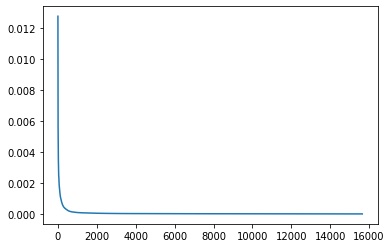

In [91]:
plt.plot(range(len(means)), means.values)

(-782.45, 2000.0)

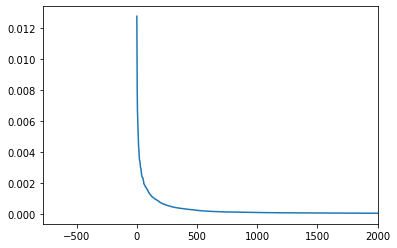

In [92]:
plt.plot(range(len(means)), means.values)
plt.xlim(right=2000)

In [93]:
means[:50]

HEPACAM      0.012748
HSD17B13     0.010914
FAM170A      0.009392
NPSR1-AS1    0.008090
CAPN11       0.007245
TKTL1        0.006677
ABCA10       0.006393
ACTBL2       0.005863
S1PR1        0.005643
NKX2-8       0.005552
E2F1         0.005340
C20orf202    0.005083
APBB3        0.004907
LCE1C        0.004735
CLDN19       0.004331
RP1L1        0.004264
TRBV10-2     0.004214
BMP5         0.004173
MARS         0.003893
AMZ1         0.003775
RPL13        0.003664
DUSP21       0.003591
HARBI1       0.003482
GLT1D1       0.003459
CARD18       0.003414
TPPP2        0.003402
NCOA3        0.003347
KLK2         0.003251
C4orf51      0.003226
ATP12A       0.003090
MTHFSD       0.003031
FOXI1        0.003008
ANGPTL7      0.002997
TPTE         0.002939
KRT86        0.002939
RRAGA        0.002811
TMEM89       0.002751
FCN2         0.002709
GPR68        0.002643
CDCP2        0.002556
DLL1         0.002462
OR8A1        0.002461
SOHLH2       0.002414
UBE2N        0.002397
BAK1         0.002385
CRCT1     